In [51]:
cd /tf/astromer

/tf/astromer


In [21]:
import matplotlib.pyplot as plt
import pandas as pd
 
from core.pretrained import ASTROMER_v1


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading data 

In [8]:
southern = ['RRab', 'RRc', 'RRd', 'Blazkho', 'EW', 'EA', 'Rotational Var', 'LPV', 'ACEP', 'Misc', 'CEPII']

In [9]:
metadata_df = pd.read_csv('./data/raw_data/css/CSS_dataset.dat')
metadata_df = metadata_df[metadata_df['Class'].isin(southern)]

In [174]:
ds_sample = pd.concat([group.sample(n=200) for lab, group in metadata_df.groupby('Class')])

In [175]:
times      = []
magnitudes = []
labels = []
for index, row in ds_sample.iterrows():
    lc = pd.read_csv('./data/raw_data/css/LCs/{}'.format(row['Path'].split('/')[-1]))
    lc = lc.sort_values('MJD')
    times.append(lc['MJD'].values)
    magnitudes.append(lc['Mag'].values)
    labels.append(row['Class'])

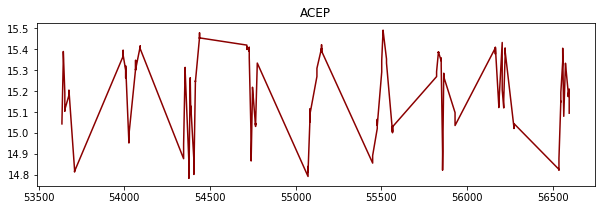

In [176]:
plt.figure(figsize=(10,3))
plt.plot(times[0], magnitudes[0], color='darkred')
plt.title('{}'.format(labels[0]))
plt.show()

### Getting attention vectors from numpy lightcurves

In [177]:
astromer = ASTROMER_v1()

In [178]:
%%time
embs = astromer.encode(times=times, magnitudes=magnitudes, batch_size=2000)

CPU times: user 56.4 s, sys: 31 s, total: 1min 27s
Wall time: 19 s


### Saving embeddings as tf.records

In [182]:
classes = list(metadata_df['Class'].unique())
labels_code = [classes.index(y) for y in labels]

In [183]:
from sklearn.model_selection import train_test_split

X_train, X_rest, y_train, y_rest = train_test_split(embs, labels_code, test_size=0.5, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

In [184]:
%%time
astromer.to_record(X_train, y_train, dest='./data/records/embeddings/train/css.record')
astromer.to_record(X_val, y_val, dest='./data/records/embeddings/val/css.record')
astromer.to_record(X_test, y_test, dest='./data/records/embeddings/test/css.record')

CPU times: user 34.5 s, sys: 497 ms, total: 35 s
Wall time: 35.3 s


### Training a classifier

In [185]:
cd /tf/astromer

/tf/astromer


In [186]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from core.pretrained import ASTROMER_v1
from core.classifier import get_mlp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [187]:
astromer = ASTROMER_v1()

In [188]:
train_batches = astromer.load_record('./data/records/embeddings/train', 
                                     batch_size=64,
                                     max_obs=500,
                                     take=20,
                                     average=True)

val_batches = astromer.load_record('./data/records/embeddings/val', 
                                   batch_size=64,
                                   max_obs=500,
                                   take=5,
                                   average=True)

test_batches = astromer.load_record('./data/records/embeddings/test', 
                                   batch_size=64,
                                   max_obs=500,
                                   take=5,
                                   average=True)

[INFO] Taking 20 balanced batches
[INFO] Taking 5 balanced batches
[INFO] Taking 5 balanced batches


In [189]:
for batch, label in dataset:
    print(label)
    break

tf.Tensor([7 2 7 5 4 2 4 0 5 3 0 5 8 5 0 3], shape=(16,), dtype=int32)


In [190]:
num_classes = metadata_df['Class'].unique().size
model = get_mlp(num_classes)
model.summary()

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256)]             0         
_________________________________________________________________
dense_85 (Dense)             (None, 512)               131584    
_________________________________________________________________
batch_normalization_27 (Batc (None, 512)               2048      
_________________________________________________________________
dense_86 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_28 (Batc (None, 256)               1024      
_________________________________________________________________
dense_87 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_29 (Batc (None, 128)               512     

In [191]:
model.compile(optimizer=Adam(learning_rate=1e-3), 
              loss=SparseCategoricalCrossentropy(from_logits=True), 
              metrics='accuracy')

In [192]:
estop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=30, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

In [193]:
%%time
hist = model.fit(train_batches, 
                 epochs=1000,
                 batch_size=256,
                 validation_data=val_batches,
                 callbacks=[estop])

Epoch 1/1000


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:591: UserWarning: Input dict contained keys ['lcid', 'length', 'label', 'input', 'mask'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


18/18 [==============================] - 5s 273ms/step - loss: 2.4051 - accuracy: 0.0782 - val_loss: 2.3978 - val_accuracy: 0.0969
Epoch 2/1000
18/18 [==============================] - 0s 12ms/step - loss: 2.3356 - accuracy: 0.1818 - val_loss: 2.3988 - val_accuracy: 0.0969
Epoch 3/1000
18/18 [==============================] - 0s 11ms/step - loss: 2.2820 - accuracy: 0.1873 - val_loss: 2.4102 - val_accuracy: 0.0969
Epoch 4/1000
18/18 [==============================] - 0s 12ms/step - loss: 2.2027 - accuracy: 0.2136 - val_loss: 2.4572 - val_accuracy: 0.0969
Epoch 5/1000
18/18 [==============================] - 0s 11ms/step - loss: 2.1005 - accuracy: 0.2491 - val_loss: 2.5048 - val_accuracy: 0.0625
Epoch 6/1000
18/18 [==============================] - 0s 12ms/step - loss: 1.9880 - accuracy: 0.2982 - val_loss: 2.9659 - val_accuracy: 0.0969
Epoch 7/1000
18/18 [==============================] - 0s 11ms/step - loss: 1.8777 - accuracy: 0.3436 - val_loss: 3.7138 - val_accuracy: 0.0969
Epoch 8/100

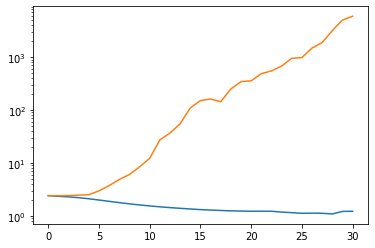

In [194]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.yscale('log')

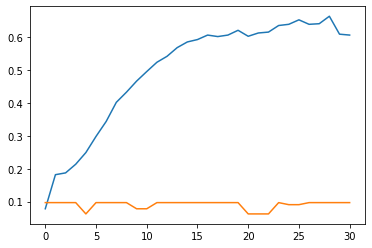

In [195]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

In [196]:
model.evaluate(test_batches)

5/5 [==============================] - 1s 201ms/step - loss: 2.3987 - accuracy: 0.1125


[2.398744583129883, 0.11249999701976776]